# How to load a data collection?

This notebook provides a detailed guide on how to load a data collection, including all the necessary steps involved. Additionally, it will explain how to authenticate your account to ensure secure access to the data.

In [1]:
# import necessary packages

import openeo

# connect to the backend
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")

To verify whether the users is authenticated, they can check if connection to the backend is authenticated. 

In [2]:
# check your connection details
connection

<Connection to 'https://openeo-staging.creo.vito.be/openeo/1.1/' with NullAuth>

If the user's connection to the backend returns a NullAuth status, it means that they are not authenticated. In this case, they can authenticate themselves by using the `authenticate_oidc()` method.

In [3]:
# authenticate and recheck for your connection
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo-staging.creo.vito.be/openeo/1.1/' with OidcBearerAuth>

After authentication to load the data collection, the next step is to filter it based on the specific requirements or criteria of the user. This involves narrowing down the dataset to a particular period or geographic location.

In [4]:
# load collection

cube = connection.load_collection(
                "SENTINEL2_L2A",
                bands=["B04", "B03", "B02", "SCL"],
                temporal_extent=("2022-05-01", "2022-05-30"),
                spatial_extent={
                    "west": 3.202609,
                    "south": 51.189474,
                    "east": 3.254708,
                    "north": 51.204641,
                    "crs": "EPSG:4326",
                },
                max_cloud_cover=50,
)

In this step we will apply cloud masking to filter out cloud pixels to make the result more usable. It is very common for earth observation data to have separate masking layers that for instance indicate whether a pixel is covered by a (type of) cloud or not. For Sentinel-2, one such layer is the “scene classification” layer generated by the Sen2Cor algorithm. In the following cells, we will use this layer to mask out unwanted data.

In [5]:
# Select the "SCL" band from the data cube
scl_cube = cube.band("SCL")

# Build mask to mask out everything but cloud
mask = (scl_cube == 7) | (scl_cube == 8)

Before we can apply this mask to the cube we have to resample it, as the “SCL” layer has a “ground sample distance” of 20 meter, while it is 10 meter for the “B02”, “B03” and “B04” bands. We can easily do the resampling by referring directly to the cube.

In [6]:
mask_resampled = mask.resample_cube_spatial(cube)

# Apply the mask to the `evi_cube`
cube_masked = cube.mask(mask_resampled)

In [7]:
# Because GeoTIFF does not support a temporal dimension, we first eliminate it by taking the temporal maximum value for each pixel

final_image = cube_masked.max_time()
image = cube.max_time()

To complete the data analysis process, the final step involves downloading the filtered data. This can be done in two ways: synchronously or through batch job-based method. Synchronous downloading allows the user to download the data immediately, whereas batch job-based downloading enables the user to download the data in batches or at a scheduled time. The choice of method depends on the user's preference and the size of the dataset. In this example we follow the first method.

In [8]:
# download the RGB image
final_image.download("output/RGB_masked.tiff")
image.download("output/RGB_withoutmask.tiff")

#### Visualize the result

In [4]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

img = rasterio.open("output/RGB_withoutmask.tiff").read()
masked_img = rasterio.open("output/RGB_masked.tiff").read()


def normalizeimg(data):
    data = data.astype(np.float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i], in_range=(p2, p98))
    return data

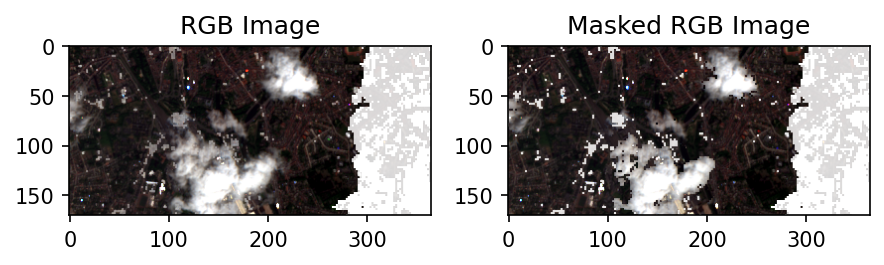

In [26]:
# Assuming you have two images img1 and img2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2), dpi=150)

# Plotting the first image on the left subplot
ax1.imshow(normalizeimg(np.moveaxis(img, 0, -1)))
ax1.set_title("RGB Image")

# Plotting the second image on the right subplot
ax2.imshow(normalizeimg(np.moveaxis(masked_img, 0, -1)))
ax2.set_title("Masked RGB Image")

# Adjusting the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()